In [17]:
#from yellowbrick.target import FeatureCorrelation
import h5py
from GNN.utils.datautils import _train_test_val_split as train_test_val_split
from GNN.utils.cm import plot_confusion_matrix
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_recall_fscore_support
#from yellowbrick.features import Rank2D
from sklearn.decomposition import PCA
from halotools.mock_observables import tpcf
import pickle
from scipy.stats import binned_statistic
#import xgboost as xgb
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import balance_dataset as bf
import seaborn as sns

sns.set_context('talk')

# Read inputs

In [9]:
additional_data_path = '/cosma5/data/dp004/hvrn44/HOD/'
output_file = 'merged_dataframe.h5'
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

In [24]:
df = pd.read_hdf(data_path + output_file)
df.columns

labels = df.N_gals > 0
features = df.drop(columns = 'N_gals')

train_idx, test_idx, val_idx = train_test_val_split(
    labels.values.shape[0],
    train_size=0.5,
)

train_features = features.iloc[train_idx]
train_labels = labels.iloc[train_idx]

test_features = features.iloc[test_idx]
test_labels = labels.iloc[test_idx]

In [2]:
hdf5_filename = "/cosma5/data/dp004/dc-cues1/features/halo_features_s99"
with h5py.File(hdf5_filename, "r+") as feats:

    
    features = np.column_stack(
        [
            feats["M200c"][:],
            feats["R200c"][:],
            feats["N_subhalos"][:],
            feats["VelDisp"][:],
            feats["Vmax"][:],
            feats["Spin"][:],
            feats["Fsub"][:],
            feats["x_offset"][:],

        ]
    )   
    
    
    positions = feats['Pos'][:] / 1000.
    boxsize = feats['boxsize'].value / 1000. # to Mpc


    #labels = np.log10(feats["stellar_mass"][:] + 1 )
    labels = feats['Ngals'][:]
    labels = labels > 0 
    


In [3]:
feature_names = ['M200c', 'R200c', 'N_subhalos', 'VelDisp', 'Vmax', 'Spin', 'Fsub', 'x_offset']

In [4]:
train_idx, test_idx, val_idx = split.train_test_val_split(labels.shape[0],
                                        train_size = 0.5)

test_idx = np.concatenate((test_idx, val_idx))
train_features = features[train_idx, :]
train_labels = labels[train_idx]
test_features = features[test_idx, :]
test_labels = labels[test_idx]




## Balance training set in the transition region

In [5]:
center_transition = 2.1e11
end_transition = 8e11

In [6]:
df_train = pd.DataFrame(dict(zip(feature_names, train_features.T)))

df_train['labels'] = train_labels

In [7]:
df_train.labels.value_counts()

True     80953
False    64350
Name: labels, dtype: int64

In [8]:
df_train_up =bf.balance_df_given_mass(df_train,
    'labels', 0., center_transition, 0, 1,
     mode = 'upsample')

df_train_up = bf.balance_df_given_mass(df_train_up,
    'labels', center_transition, end_transition, 1, 0,
     mode = 'upsample')

In [9]:
df_train_up[df_train_up.M200c < center_transition].labels.value_counts()

True     58378
False    58378
Name: labels, dtype: int64

In [10]:
df_train_up[(df_train_up.M200c > center_transition) & (df_train_up.M200c < end_transition)].labels.value_counts()

True     48837
False    48837
Name: labels, dtype: int64

In [11]:
df_train_up_features = df_train_up.drop(columns = 'labels')
df_train_up_labels = df_train_up['labels']

In [12]:
df_train_up_labels.value_counts()

True     131575
False    107215
Name: labels, dtype: int64

In [16]:
df_train_down =bf.balance_df_given_mass(df_train,
    'labels', 0., center_transition, 0, 1,
     mode = 'downsample')

df_train_down = bf.balance_df_given_mass(df_train_down,
    'labels', center_transition, end_transition, 1, 0,
     mode = 'downsample')

In [17]:
df_train_down_features = df_train_down.drop(columns = 'labels')
df_train_down_labels = df_train_down['labels']

In [18]:
df_train_down_labels.value_counts()

True     38088
False    13728
Name: labels, dtype: int64

# Standarize features

In [19]:

scaler = StandardScaler()

scaler.fit(df_train_down_features)

std_train_features = scaler.transform(df_train_down_features)
test_features = scaler.transform(test_features)


# Random Forest on downsampled Features

In [20]:
n_estimators = 500

rf = RandomForestClassifier(n_estimators= n_estimators)

rf.fit(std_train_features, df_train_down_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
test_pred = rf.predict(test_features)

In [22]:
test_masses = scaler.inverse_transform(test_features)[:,0]

len(test_masses)

145302

In [23]:
assert np.sum(test_pred[test_masses > end_transition]) == len(test_pred[test_masses > end_transition])

Normalized confusion matrix


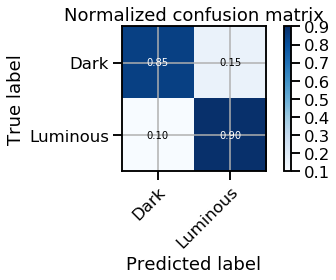

In [24]:
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)
plt.grid(b=None)

In [25]:
# truly luminous classified as luminous ( true positives)
np.sum(test_labels[test_labels > 0 ] == test_pred[test_labels > 0 ])
# truly dark classified as dark ( true negatives)
np.sum(test_labels[test_labels == 0 ] == test_pred[test_labels == 0 ])

54603

In [26]:
len(test_labels[test_labels > 0 ] == test_pred[test_labels > 0 ])

81054

In [27]:
nbins= 15
bins = np.logspace(11,
                   12, nbins+1)

true_positives, edges, _ = binned_statistic(test_masses[test_labels > 0],
                    test_labels[test_labels > 0 ] == test_pred[test_labels > 0 ],
                    statistic = 'mean', bins = bins)


true_negatives, edges, _ = binned_statistic(test_masses[test_labels == 0],
                    test_labels[test_labels == 0 ] == test_pred[test_labels == 0 ],
                    statistic = 'mean', bins = bins)

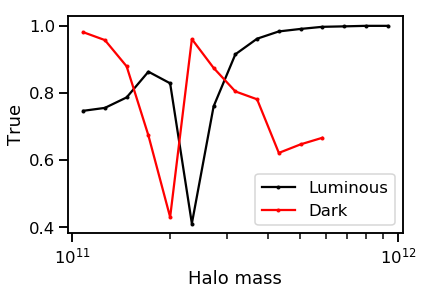

In [28]:
plt.semilogx((edges[1:]+edges[:-1])/2.,
           true_positives,color='black', marker='o',markersize=3,
            label = 'Luminous')
plt.semilogx((edges[1:]+edges[:-1])/2.,
           true_negatives,color='red', marker='o',markersize=3,
            label = 'Dark')
plt.ylabel('True')
plt.xlabel('Halo mass')
plt.legend()

In [29]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                     axis=0)
indices = np.argsort(importances)[::-1]


In [30]:
feature_names = np.array(feature_names)

In [31]:
sns.set_context('paper')

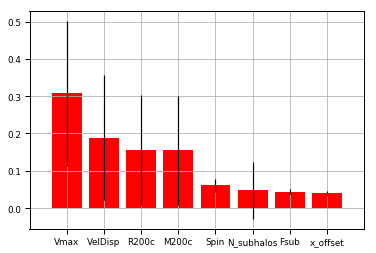

In [32]:
plt.bar(range(train_features.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), feature_names[indices])
plt.xlim([-1, train_features.shape[1]])

plt.grid(b=None)

## Compare correlation functions

In [33]:
pos_test = positions[test_idx, :]

pos_test_galaxies = pos_test[test_labels]

r = np.geomspace(0.3, 30., 50)
r_c = 0.5 * (r[1:] + r[:-1])


test_tpcf = tpcf(pos_test_galaxies, rbins = r,
    period = boxsize, estimator =  'Landy-Szalay' )

In [34]:
pos_test_pred = positions[test_idx][test_pred]


predicted_tpcf = tpcf(pos_test_pred, rbins = r, 
    period = boxsize, estimator =  'Landy-Szalay' )

In [38]:
with open('hod_tpcf.pkl', 'rb') as f:
    hod_tpcf = pickle.load(f)

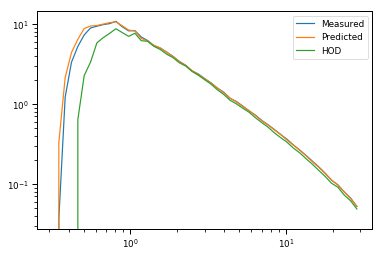

In [39]:
plt.loglog(r_c, test_tpcf, label = 'Measured')
plt.loglog(r_c, predicted_tpcf, label = 'Predicted')
plt.loglog(hod_tpcf['r_c'],
           hod_tpcf['tpcf'], label = 'HOD')

plt.legend()

Text(0.5,0,'$r$ [Mpc/h]')

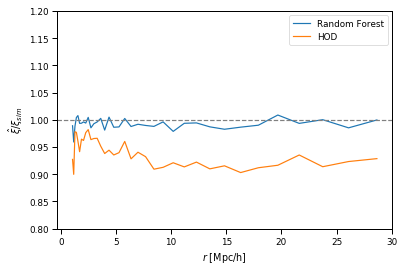

In [46]:
plt.plot(r_c[r_c > 1], (predicted_tpcf/test_tpcf)[r_c > 1], label = 'Random Forest')
plt.plot(r_c[r_c > 1], (hod_tpcf['tpcf']/test_tpcf)[r_c > 1] , label = 'HOD', )

plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)
plt.ylabel(r'$\hat{\xi}/\xi_{sim}$')
plt.xlabel(r'$r$ [Mpc/h]')

## Upsampled haloes

In [96]:
scaler = StandardScaler()

scaler.fit(df_train_up_features)

std_train_features = scaler.transform(df_train_up_features)
test_features = scaler.transform(test_features)


In [85]:

rf.fit(std_train_features, df_train_up_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
test_pred = rf.predict(test_features)

In [98]:
test_masses = scaler.inverse_transform(test_features)[:,0]

len(test_masses)

145302

In [99]:
assert np.sum(test_pred[test_masses > end_transition]) == len(test_pred[test_masses > end_transition])

Normalized confusion matrix


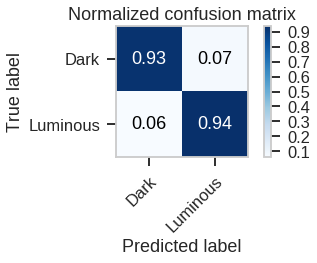

In [100]:
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)
plt.grid(b=None)

In [101]:
pos_test = positions[test_idx, :]

pos_test_galaxies = pos_test[test_labels]

r = np.geomspace(0.3, 10., 20)
r_c = 0.5 * (r[1:] + r[:-1])


test_tpcf = tpcf(pos_test_galaxies, rbins = r,
    period = boxsize, estimator =  'Landy-Szalay' )

In [102]:
pos_test_pred = positions[test_idx][test_pred]


predicted_tpcf = tpcf(pos_test_pred, rbins = r, 
    period = boxsize, estimator =  'Landy-Szalay' )

(0.8, 1.2)

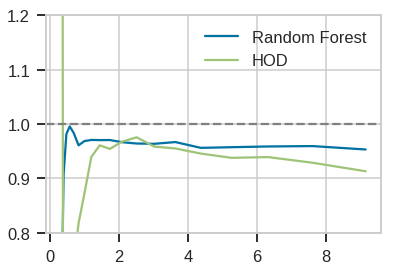

In [103]:
plt.plot(r_c, predicted_tpcf/test_tpcf, label = 'Random Forest')
plt.plot(r_c, hod_tpcf['tpcf']/test_tpcf, label = 'HOD', )

plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)

In [104]:
nbins= 15
bins = np.logspace(11,
                   12, nbins+1)

true_positives, edges, _ = binned_statistic(test_masses[test_labels > 0],
                    test_labels[test_labels > 0 ] == test_pred[test_labels > 0 ],
                    statistic = 'mean', bins = bins)


true_negatives, edges, _ = binned_statistic(test_masses[test_labels == 0],
                    test_labels[test_labels == 0 ] == test_pred[test_labels == 0 ],
                    statistic = 'mean', bins = bins)

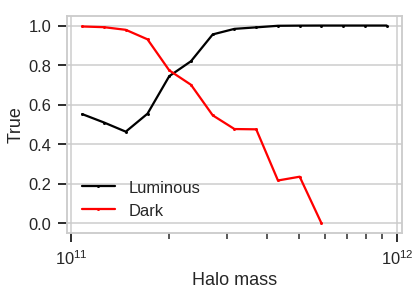

In [105]:
plt.semilogx((edges[1:]+edges[:-1])/2.,
           true_positives,color='black', marker='o',markersize=3,
            label = 'Luminous')
plt.semilogx((edges[1:]+edges[:-1])/2.,
           true_negatives,color='red', marker='o',markersize=3,
            label = 'Dark')
plt.ylabel('True')
plt.xlabel('Halo mass')
plt.legend()